In [14]:
# -*- coding: utf-8 -*-
"""
Exemple de réseau de neuronne à propagation avant et
rétropropagation de l'erreur pour l'apprentissage
"""
import random
import numpy as np
np.random.seed(42) # pour reproduire les mêmes résultats
random.seed(42)
import matplotlib.pyplot as plt

def sigmoide(z):
    """The sigmoide function."""
    return 1.0/(1.0+np.exp(-z))

def derivee_sigmoide(z):
    """Derivative of the sigmoide function."""
    return sigmoide(z)*(1-sigmoide(z))

def bitmap(classe):
    """ Representer l'entier de classe par un vecteur bitmap (10,1) 
    classe : entier entre 0 et 9 qui représente la classe de l'observation"""
    e = np.zeros((2, 1))
    e[classe] = 1.0
    return e

class RNA(object):
    """ Un RNA est un réseau de neuronnes artificiel multi-couche.
    """
        
    def __init__(self, ncs):
        """ ncs[c] contient le nombre de neurones de la couche c, c = 0 ...nombre_couches-1
        la couche d'indice 0 est la couche d'entrée
        ncs[nombre_couches-1] doit correspondre au nombre de catégories des y (sortie)
        
        liste_w[c] est la matrice des poids entre la couche c et c+1
        liste_w[c][i,j] est le poids entre le neuronne i de la couche c+1 et j de la couche c
        i = 0 correspond au biais par convention
        les poids sont initialisés avec un nombre aléatoire selon une distribution N(0,1)
        """
        self.nombre_couches = len(ncs)
        self.ncs = ncs
        self.liste_w = [np.random.randn(x+1,y) for x, y in zip(ncs[:-1], ncs[1:])]
        print(self.liste_w)

    def propagation_avant_w(self, activation):
        """
        Traiter une entrée par propagation avant
        
        activation: activation initiale qui correspond aux entrées (taille self.ncs[0])
        retourne l'activation de sortie après propagation avant"""
        
        for w in self.liste_w:
            activation = np.vstack((np.ones(1),sigmoide(np.dot(w.transpose(),activation))))
        return activation

    def entrainer_par_mini_lot(self,donnees_entrainement,donnees_test,nombre_epochs,taille_mini_lot,eta):
        """
        Entrainer le RNA par mini-lots
        Affiche le nombre de bons résultats des donnees_test pour chaque epoch
        
        donnees_entrainement : liste de tuples (x,y) pour l'entrainement où
            x est un tableau de taille (ncs[0],1) où n est la taille des entrées
            y est un encodage bitmap de la catégorie en tableau de taille ncs[nombre_couches-1]
        donnees_test : liste de tuples (x,y) pour les tests
            x est un tableau de taille (ncs[0],1) où n est la taille des entrées
            y un int où 0<=y< nombre de catégories
        nombre_epochs : nombre de passe d'entrainement
        taille_mini_lot : la taille de chacun des mini-lots
        eta : vitesse d'apprentissage
        """
        n_test = len(donnees_test)
        n_ent = len(donnees_entrainement)
        self.liste_eqm_ent = []
        self.liste_ok_ent = []
        self.liste_eqm_test = []
        self.liste_ok_test = []
        
        for j in range(nombre_epochs):
            random.shuffle(donnees_entrainement)
            mini_lots = [donnees_entrainement[k:k+taille_mini_lot] for k in range(0, n_ent, taille_mini_lot)]
            # Entrainer un mimi-lot à la fois
            for mini_lot in mini_lots:
                # Initialiser les gradiants totaux à 0
                liste_dJ_dw = [np.zeros(w.shape) for w in self.liste_w]
                for x, y in mini_lot:
                    dJ_dw_une_ligne = self.retropropagation_w(x, y)
                    # ajouter les gradiants d'une observation aux totaux partiels du lot
                    liste_dJ_dw = [dJ_dw+dJ_dw_1 for (dJ_dw, dJ_dw_1) in zip(liste_dJ_dw, dJ_dw_une_ligne)]
                # mettre à jour les paramètres du RNA avec les gradiants du lot    
                self.liste_w = [w-(eta/len(mini_lot))*dw  for (w, dw) in zip(self.liste_w, liste_dJ_dw)]
                print(self.liste_w)

            
             # Calcul des métriques de performance
            eqm_ent,ok_ent = self.metriques(donnees_entrainement)
            eqm_test,ok_test = self.metriques(donnees_test)
            self.liste_eqm_ent.append(eqm_ent/n_ent)
            self.liste_ok_ent.append(ok_ent/n_ent)
            self.liste_eqm_test.append(eqm_test/n_test)
            self.liste_ok_test.append(ok_test/n_test)
            print("Epoch {0}: EQM entrainement: {1} Taux correct: {2}".format(j, eqm_ent/n_ent,ok_ent/n_ent))
            print("Epoch {0}: EQM test: {1} Taux correct: {2}".format(j, eqm_test/n_test,ok_test/n_test))

        # Affichage des graphiques d'évolution des performances par epoch
        plt.plot(np.arange(0,nombre_epochs),self.liste_eqm_ent,label='Eqm entraînement')
        plt.plot(np.arange(0,nombre_epochs),self.liste_eqm_test,label='Eqm test')
        plt.title("Erreur quadratique moyenne")
        plt.xlabel('epoch')
        plt.ylabel('erreur')
        plt.legend(loc='upper center')
        plt.show()

        plt.plot(np.arange(0,nombre_epochs),self.liste_ok_ent,label='Nb correct entraînement')
        plt.plot(np.arange(0,nombre_epochs),self.liste_ok_test,label='Nb correct test')
        plt.title("Taux de bonnes réponses")
        plt.xlabel('epoch')
        plt.ylabel('nb correct')
        plt.legend(loc='upper center')
        plt.show()
    
    def retropropagation_w(self, x, y):
        """Return a tuple ``(dJ_db, dJ_dw)`` representing the
        gradient for the cost function C_x.  ``dJ_db`` and
        ``dJ_dw`` are layer-by-layer lists of numpy arrays, similar
        to ``self.liste_biais`` and ``self.liste_w``."""
        dJ_dw = [np.zeros(w.shape) for w in self.liste_w]

        # propagation_avant
        activation = np.vstack((np.ones(1),x)) # activation
        activations = [np.vstack((np.ones(1),x))] # liste des activations couche par couche
        zs = [] # liste des z par couche
        for w in self.liste_w:
            z = np.dot(w.transpose(),activation)
            zs.append(z)
            activation = np.vstack((np.ones(1),sigmoide(z))) 
            activations.append(activation)
        
        # retropropagation
        dJ_dz = self.dJ_da_final(activations[-1][1:], y)*derivee_sigmoide(zs[-1])
        dJ_dw[-1] = np.dot(activations[-2],dJ_dz.transpose())
        # itérer de la couche nc-2 à la couche 1
        for l in range(2, self.nombre_couches):
            z = zs[-l]
            sp = derivee_sigmoide(z)
            dJ_dz = np.dot(self.liste_w[-l+1], dJ_dz)[1:] * sp
            dJ_dw[-l] = np.dot(activations[-l-1], dJ_dz.transpose())
        return dJ_dw

    def metriques(self, donnees):
        """Retourne le nombre de bons résultats
        Choisit l'indice de la classe dont l'activation est la plus grande"""
        erreur_quadratique = 0
        nb_correct = 0
        for (x,y) in donnees:
            resultat_propagation = self.propagation_avant_w(np.vstack((np.ones(1),x)))[1:]
            erreur_quadratique += sum((resultat_propagation-y)**2)
            classe_predite = np.argmax(resultat_propagation)
            if y[classe_predite] == 1:
                nb_correct+=1
        return (erreur_quadratique,nb_correct)

    def dJ_da_final(self, output_activations, y):
        """Dérivée de J par rapport à l'activation"""
        return (output_activations-y)

In [11]:
x_ent = [[[0],[0]],[[1],[1]]]
y_ent = [bitmap(y) for y in [[0],[1]]]
donneesxy_ent = list(zip(x_ent, y_ent))
x_test = [[[0],[0]],[[1],[1]]]
y_test = [bitmap(y) for y in [[0],[1]]]
donneesxy_test = list(zip(x_test, y_test))

[array([[ 0.49671415, -0.1382643 ],
       [ 0.64768854,  1.52302986],
       [-0.23415337, -0.23413696]]), array([[ 1.57921282,  0.76743473],
       [-0.46947439,  0.54256004],
       [-0.46341769, -0.46572975]])]
[array([[ 0.51812018, -0.13152587],
       [ 0.66909456,  1.52976829],
       [-0.21274735, -0.22739852]]), array([[ 1.43296805,  0.83371477],
       [-0.57375439,  0.5898211 ],
       [-0.57450898, -0.41538173]])]
[array([[ 0.48946893, -0.12612434],
       [ 0.66909456,  1.52976829],
       [-0.21274735, -0.22739852]]), array([[ 1.49893112,  0.69024181],
       [-0.5324148 ,  0.49990544],
       [-0.54369328, -0.4824074 ]])]
Epoch 0: EQM entrainement: [0.55479835] Taux correct: 0.5
Epoch 0: EQM test: [0.55479835] Taux correct: 0.5
[array([[ 0.46472541, -0.11628054],
       [ 0.66909456,  1.52976829],
       [-0.21274735, -0.22739852]]), array([[ 1.55738506,  0.54241445],
       [-0.49617445,  0.40825524],
       [-0.51630699, -0.55166609]])]
[array([[ 0.48757387, -0.1120734

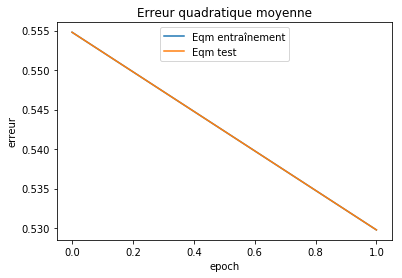

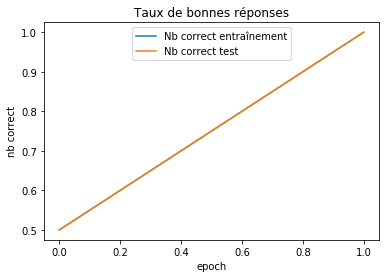

In [15]:
# Classification par RNA
net = RNA([2, 2, 2])
net.entrainer_par_mini_lot(donneesxy_ent,donneesxy_test,2,1,1.0)

In [12]:
donneesxy_ent

[([[0], [0]], array([[1.],
         [0.]])), ([[1], [1]], array([[0.],
         [1.]]))]

[[[0], [0]], [[1], [1]]]

list